In [2]:

import os
import time
import numpy as np

mask = np.zeros((104,), dtype=bool)  # CHANGE NUMBER OF TIME SERIES
mask[0:26] = True
mask[52:78] = True
observations = np.array([274.4926576260765,
                         598.0892112209613,
                         754.6480525229028,
                         788.3757246593943,
                         755.0194538701197,
                         708.2718340488675,
                         655.959789868714,
                         614.4782050188968,
                         594.3969941554566,
                         567.1784724261873,
                         530.437457407308,
                         523.4864235733296,
                         519.9855749187057,
                         488.6575738795287,
                         473.09716489452796,
                         449.2542960747279,
                         427.5164686623572,
                         375.8723373183419,
                         350.19813812448,
                         326.95301280994255,
                         308.36140845047123,
                         300.99859274112134,
                         304.6445759333955,
                         284.82751573597614,
                         293.82352453078687,
                         297.78797790282147,
                         291.4849567309765,
                         427.3638011934589,
                         515.4337003791222,
                         567.8790684812916,
                         587.8187262698602,
                         596.2997622233817,
                         600.231433933479,
                         604.2426716794303,
                         604.4891026415579,
                         604.5939753561715,
                         600.3968315843018,
                         599.0936706210072,
                         600.1026806406614,
                         601.0549659469995,
                         599.3677522479395,
                         599.5797928528933,
                         600.9897501965371,
                         581.2308316659297,
                         571.3860699657665,
                         554.6971661958914,
                         551.7510989075095,
                         549.6828347262143,
                         547.889850393989,
                         545.5079911709897,
                         541.8464909658526,
                         539.8831507926769,
                         262.00970108619634,
                         62.843249986131575,
                         48.08262448100288,
                         42.681038591463576,
                         42.93917678143266,
                         45.08236786944522,
                         49.94181194643198,
                         56.007637102484054,
                         61.35265637436543,
                         60.28968371081408,
                         59.66429769637641,
                         60.60653451083565,
                         79.19950050268767,
                         81.48672728810196,
                         91.97984245675362,
                         90.06164513633016,
                         89.22193608913719,
                         79.33002552259684,
                         79.32797971798708,
                         82.6842177813621,
                         77.31306993967296,
                         78.0024018399629,
                         85.3324173501424,
                         75.85212647719274,
                         82.55973059689288,
                         89.09948153884811,
                         257.9008844392112,
                         191.8287457093792,
                         182.31709971106727,
                         190.03880788853837,
                         199.5573905516005,
                         206.60667527936772,
                         212.1567669151635,
                         219.18237427174483,
                         224.15477335342234,
                         227.27468809909988,
                         229.70971358027575,
                         231.4502625076091,
                         241.01151025625674,
                         255.277187867922,
                         263.4366858776309,
                         269.2751968638125,
                         277.37742794161676,
                         279.18456592155275,
                         280.9663593020484,
                         280.60601465805485,
                         284.33732517425176,
                         287.4831045118054,
                         291.9119196569415,
                         293.8776530350752,
                         296.58050178462213,
                         295.5639271117169]).reshape(1, -1)
observations = observations.flatten()
observations = observations[mask]

par = np.load(os.path.join("", "par.npy"))
obs = np.load(os.path.join("", "obs.npy"))
print("Snapshots loaded", par.shape, obs.shape, flush=True)

np.random.seed(0)
indices = np.random.permutation(par.shape[0])
par = par[indices]
obs = obs[indices] / 275
par_train = par[:int(0.8 * par.shape[0])]
obs_train = obs[:int(0.8 * obs.shape[0])]
par_test = par[int(0.8 * par.shape[0]):]
obs_test = obs[int(0.8 * obs.shape[0]):]

Snapshots loaded (28324, 30) (28324, 52)


In [13]:
observations.size

52

In [3]:
all_test_losses = []
all_train_losses = []

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

class PyTorchMLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, activation):
        super(PyTorchMLP, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_layers = hidden_layers
        self.activation = activation
        activation_layer = self.create_activation_layer(activation)
        layers = [nn.Linear(input_size, hidden_layers[0]), activation_layer]
        for i in range(1, len(hidden_layers)):
            layers.append(nn.Linear(hidden_layers[i - 1], hidden_layers[i]))
            activation_layer = self.create_activation_layer(activation)
            layers.append(activation_layer)
        layers.append(nn.Linear(hidden_layers[-1], output_size))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

    def create_activation_layer(self, activation):
        if activation == 'relu':
            activation_layer = nn.ReLU()
        else:
            activation_layer = nn.Tanh()
        return activation_layer

In [5]:
no_parameters = 30
no_observations = 52
hidden_layer_sizes = (100, 100, 100, 100, 100, 100, 100)
activation = 'tanh'

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", DEVICE, flush=True)

model = PyTorchMLP(no_parameters, no_observations, hidden_layer_sizes, activation)
model.to(DEVICE)

par_train_tensor = torch.tensor(par_train, dtype=torch.float32, device=DEVICE)
obs_train_tensor = torch.tensor(obs_train, dtype=torch.float32, device=DEVICE)
par_test_tensor = torch.tensor(par_test, dtype=torch.float32, device=DEVICE)
obs_test_tensor = torch.tensor(obs_test, dtype=torch.float32, device=DEVICE)

Device: cuda


/usr/lib/python3.13/site-packages/torch/cuda/__init__.py:283: UserWarning: 
    Found GPU0 NVIDIA GeForce GTX 1080 Ti which is of cuda capability 6.1.
    Minimum and Maximum cuda capability supported by this version of PyTorch is
    (7.5) - (12.1)
    
  warnings.warn(
/usr/lib/python3.13/site-packages/torch/cuda/__init__.py:304: UserWarning: 
    Please install PyTorch with a following CUDA
    configurations:  12.6 following instructions at
    https://pytorch.org/get-started/locally/
    
  warnings.warn(matched_cuda_warn.format(matched_arches))
/usr/lib/python3.13/site-packages/torch/cuda/__init__.py:326: UserWarning: 
NVIDIA GeForce GTX 1080 Ti with CUDA capability sm_61 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_75 sm_80 sm_86 sm_87 sm_89 sm_90 sm_100 sm_103 sm_110 sm_120 sm_121.
If you want to use the NVIDIA GeForce GTX 1080 Ti GPU with PyTorch, please check the instructions at https://pytorch.org/get-star

In [6]:
dataset_train = torch.utils.data.TensorDataset(par_train_tensor, obs_train_tensor)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=1000, shuffle=True, pin_memory=True)

In [7]:
# PRETRAINING

nn_pretrain = 1000

In [8]:
learning_rate_init = 1e-5
optimizer1 = optim.Adam(model.parameters(), lr=learning_rate_init)
optimizer2 = optim.LBFGS(model.parameters(), lr=0.5, line_search_fn="strong_wolfe")
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer1, mode='min', factor=0.01, patience=200)
criterionL1 = nn.L1Loss()
criterionMSE = nn.MSELoss()




def exp_loss(predicitons, observations):
    return ((torch.abs(predicitons - observations))**(4)).mean()


criterion_train = criterionL1
criterion_test = criterionMSE

In [9]:
epochs = 100
test_losses = []
train_losses = []

data_select = slice(0, 1000)
def closure_2():
    optimizer.zero_grad()
    obs_pred = model(par_train_tensor_loc[data_select,:])
    loss = criterion_train(obs_pred, obs_train_tensor_loc[data_select,:])
    loss.backward()
    return loss


for added_samples in range(1, 12001):
    added_samples = min(added_samples * 100000, par_train_tensor.shape[0])
    par_train_tensor_loc = par_train_tensor[:added_samples,:].clone()
    obs_train_tensor_loc = obs_train_tensor[:added_samples,:].clone()

    for epoch in range(1,epochs+1):
        # for i, (par_batch, obs_batch) in enumerate(dataloader_train):
        #     def closure():
        #         optimizer.zero_grad()
        #         obs_pred = model(par_batch)
        #         loss = criterion_train(obs_pred, obs_batch)
        #         loss.backward()
        #         return loss
        #     print("Optimizing", flush=True)
        #     optimizer.step(closure)
        if np.random.rand() < 0.9:
            criterion_train = criterionMSE
        else:
            criterion_train = criterionL1

        if np.random.rand() < 0.9:
            optimizer = optimizer1
        else:
            optimizer = optimizer2
        
        stride = min(max(added_samples // 10000, 1),1)
        data_select = slice(np.random.randint(0, stride), -1, stride)
        optimizer.step(closure_2)
        if epoch % 100 == 0:
            with torch.no_grad():
                obs_pred_train = model(par_train_tensor_loc)
                loss_train = criterionMSE(obs_pred_train, obs_train_tensor_loc)
                scheduler.step(loss_train)
                obs_pred_test = model(par_test_tensor)
                loss_test = criterion_test(obs_pred_test, obs_test_tensor)
                test_losses.append(loss_test.item())
                train_losses.append(loss_train.item())
                print(
                    f"Samples {added_samples}, IT {epoch}, Stride {stride}, Train loss: {
                        loss_train.item():.4e}, Test loss: {
                        loss_test.item():.4e}, LR {
                        optimizer.param_groups[0]["lr"]}",
                    flush=True)

RuntimeError: CUDA error: CUBLAS_STATUS_ARCH_MISMATCH when calling `cublasCreate(handle)`

In [ ]:
all_test_losses.append(test_losses)
all_train_losses.append(train_losses)

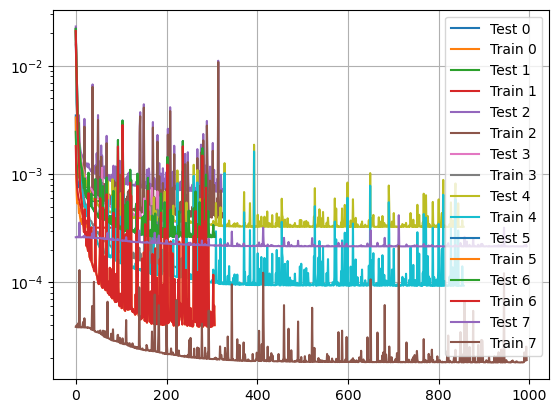

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
i = 0
for test_losses, train_losses in zip(all_test_losses, all_train_losses):

    plt.plot(test_losses, label=f"Test {i}")
    plt.plot(train_losses, label=f"Train {i}")
    i += 1

plt.yscale("log")
#plt.xscale("log")
plt.legend()
plt.grid()
plt.show()

Loss 1.4256717804528307e-05


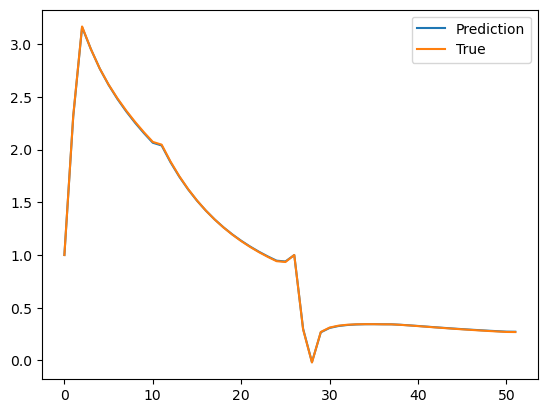

In [ ]:
sample = np.random.randint(0, par_test_tensor.shape[0])

with torch.no_grad():
    obs_pred = model(par_test_tensor[sample,:])
    loss = criterion_test(obs_pred, obs_test_tensor[sample,:])
    print("Loss", loss.item())
    obs_pred = obs_pred.cpu().numpy()
    obs_test = obs_test_tensor[sample,:].cpu().numpy()
    plt.figure()
    plt.plot(obs_pred, label="Prediction")
    plt.plot(obs_test, label="True")
    plt.legend()
    plt.show()


(array([4.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00,
        5.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00,
        1.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00, 3.0000e+00,
        2.0000e+00, 4.0000e+00, 1.2000e+01, 6.0000e+00, 1.6000e+01,
        1.2000e+01, 1.3000e+01, 2.3000e+01, 5.4000e+01, 7.3000e+01,
        1.2100e+02, 1.4200e+02, 3.1300e+02, 5.8900e+02, 1.4570e+03,
        4.0660e+03, 2.3055e+04, 5.5187e+04, 3.9651e+04, 1.1147e+04,
        3.5850e+03, 1.9210e+03, 1.3900e+03, 3.3660e+03, 1.9409e+04,
        1.1586e+04, 1.1340e+04, 9.6190e+03, 8.1030e+03, 6.9560e+03,
        6.2400e+03, 5.6220e+03, 5.8630e+03, 6.8980e+03, 8.0970e+03,
        8.3870e+03, 7.5060e+03, 6.6630e+03, 6.1180e+03, 5.4200e+03,
        4.5860e+03, 3.5280e+03, 2.3910e+03, 1.5400e+03, 9.1600e+02,
        5.2000e+02, 2.9200e+02, 1.8700e+02, 1.2600e+02, 8.8000e+01,
        8.4000e+01, 5.8000e+01, 4.1000e+01, 3.40

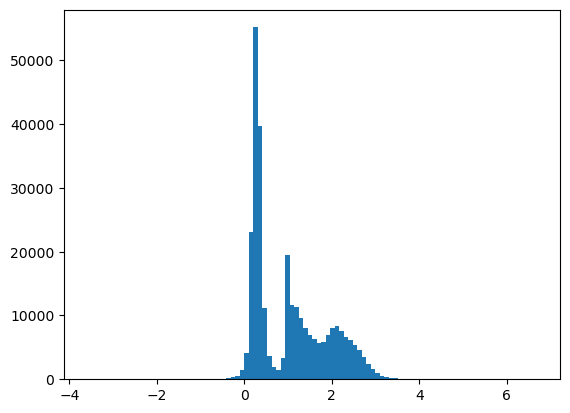

In [12]:
import matplotlib.pyplot as plt

plt.hist(obs_test_tensor.reshape(-1).cpu().numpy(), bins=100)

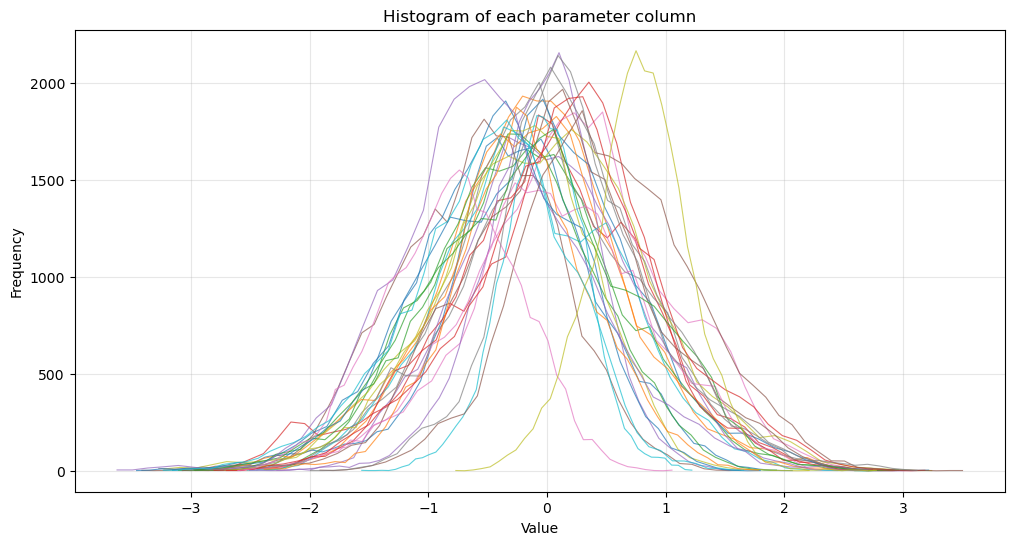

In [15]:
plt.figure(figsize=(12, 6))
for i in range(par.shape[1]):
    counts, bins = np.histogram(par[:, i], bins=50)
    plt.plot(bins[:-1], counts, alpha=0.7, linewidth=0.8)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of each parameter column')
plt.grid(True, alpha=0.3)
plt.show()

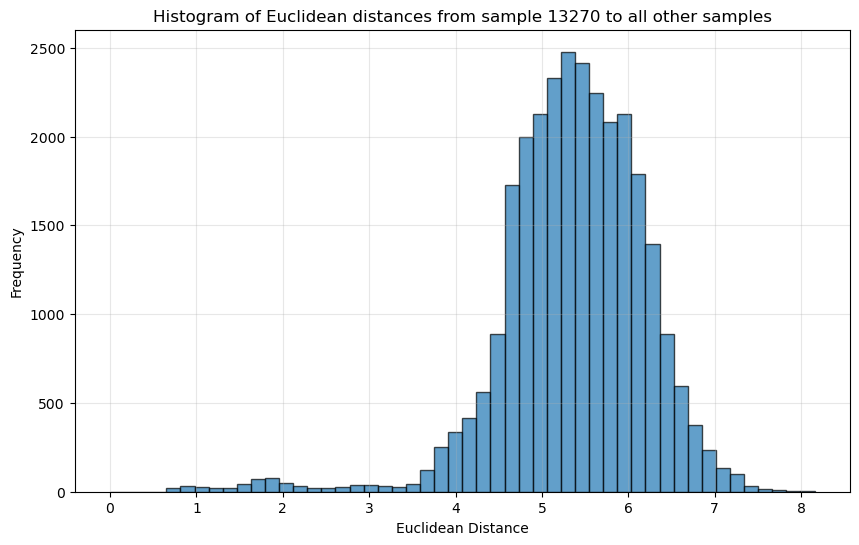

Sample index: 13270
Min distance: 0.6073
Max distance: 8.1547
Mean distance: 5.3597


In [25]:
# Draw a random sample
random_idx = np.random.randint(0, par.shape[0])
random_sample = par[random_idx, :]

# Compute Euclidean distances to all other rows
distances = np.linalg.norm(par - random_sample, axis=1)

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(distances, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title(f'Histogram of Euclidean distances from sample {random_idx} to all other samples')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Sample index: {random_idx}")
print(f"Min distance: {distances[distances > 0].min():.4f}")
print(f"Max distance: {distances.max():.4f}")
print(f"Mean distance: {distances.mean():.4f}")

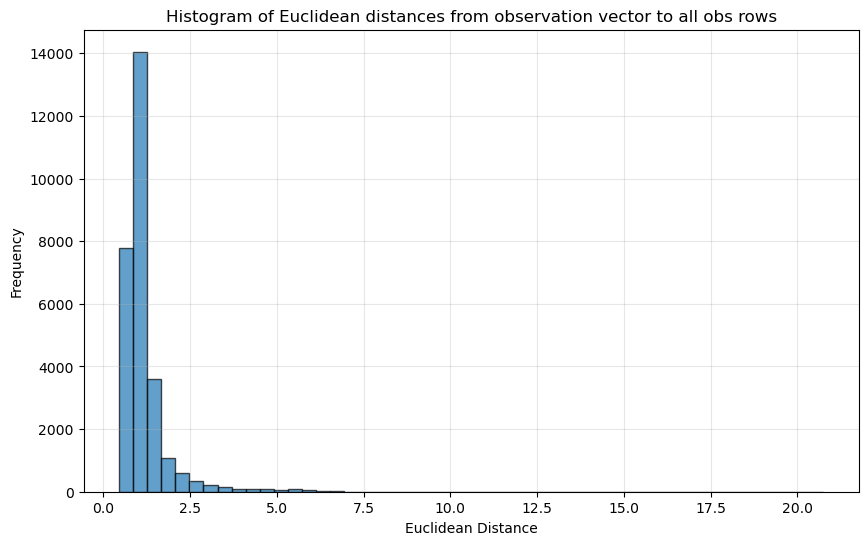

Min distance: 0.4479
Max distance: 20.7491
Mean distance: 1.1805


In [28]:
# Compute Euclidean distances from observations vector to all rows in obs
distances_obs = np.linalg.norm(obs - observations/275, axis=1)

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(distances_obs, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Euclidean distances from observation vector to all obs rows')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Min distance: {distances_obs.min():.4f}")
print(f"Max distance: {distances_obs.max():.4f}")
print(f"Mean distance: {distances_obs.mean():.4f}")

In [235]:
from typing import Optional, Literal, Tuple
import math
from typing import Optional, Sequence, Tuple
import numpy as np
import scipy.sparse as sp
from sklearn.neighbors import NearestNeighbors

# -----------------------------
# 1) Sparse proposal on points
# -----------------------------


def build_transition_matrix_knn(
    points: np.ndarray,
    sigma_prop: float = 0.2,
    k: int = 64,
    include_self_loop: bool = True,
    self_weight: float = 1.0,
    n_jobs: int = -1,
) -> sp.csr_matrix:
    """
    Build a symmetric, row-stochastic proposal T over points using k-NN
    with Gaussian weights: w_ij = exp(-||x_i - x_j||^2 / (2 * sigma_prop^2)).

    We insert both (i->j) and (j->i) so that if i proposes j, the reverse
    probability q(j->i) is also > 0 (important for MH acceptance).

    Parameters
    ----------
    points : (n, d) array
    sigma_prop : float
        Proposal std (same for all dims). Start with 0.2 as requested.
    k : int
        #neighbors per node (not counting self). 32–128 is a good range.
    include_self_loop : bool
        Add i->i with weight self_weight before normalization.
    self_weight : float
        Raw self weight prior to row-normalization. 1.0 is a good default.
    n_jobs : int
        Parallelism for sklearn neighbors.

    Returns
    -------
    T : csr_matrix (n x n)
        Row-stochastic transition matrix (proposal).
    """
    X = np.asarray(points, dtype=np.float64, order="C")
    n = X.shape[0]
    if n == 0:
        raise ValueError("No points.")
    if sigma_prop <= 0:
        raise ValueError("sigma_prop must be positive.")
    if k < 1 or k >= n:
        raise ValueError("k must be in [1, n-1].")

    # k+1 to include self (dist 0) returned by kneighbors
    nn = NearestNeighbors(n_neighbors=k + 1, algorithm="auto", n_jobs=n_jobs)
    nn.fit(X)
    dists, nbrs = nn.kneighbors(X, return_distance=True)

    rows = []
    cols = []
    data = []

    inv_two_sig2 = 1.0 / (2.0 * sigma_prop * sigma_prop)

    for i in range(n):
        nb = nbrs[i]
        ds = dists[i]
        # skip the first neighbor if it's self (distance 0)
        start = 1 if nb[0] == i else 0
        nb = nb[start:]
        ds = ds[start:]

        w = np.exp(-(ds * ds) * inv_two_sig2)

        # Add both directions with the SAME weight (symmetrize adjacency)
        # i -> j
        rows.append(np.full(nb.size, i, dtype=np.int32))
        cols.append(nb.astype(np.int32, copy=False))
        data.append(w.astype(np.float64, copy=False))
        # j -> i
        rows.append(nb.astype(np.int32, copy=False))
        cols.append(np.full(nb.size, i, dtype=np.int32))
        data.append(w.astype(np.float64, copy=False))

        if include_self_loop:
            rows.append(np.array([i], dtype=np.int32))
            cols.append(np.array([i], dtype=np.int32))
            data.append(np.array([self_weight], dtype=np.float64))

    rows = np.concatenate(rows)
    cols = np.concatenate(cols)
    data = np.concatenate(data)

    W = sp.csr_matrix((data, (rows, cols)), shape=(n, n))
    W.sum_duplicates()

    # Row-normalize to get probabilities
    rs = np.asarray(W.sum(axis=1)).ravel()
    # ensure no zero rows (k-NN + self-loop should prevent this)
    empty = np.where(rs == 0)[0]
    if empty.size:
        W = W + sp.csr_matrix((np.ones(empty.size), (empty, empty)), shape=(n, n))
        rs = np.asarray(W.sum(axis=1)).ravel()

    inv = np.reciprocal(rs, where=rs > 0)
    T = sp.diags(inv) @ W
    T.eliminate_zeros()
    return T.tocsr()

# -------------------------------------------
# 2) Unnormalized posterior on the snapshots
# -------------------------------------------


def log_posterior_unnorm(
    par: np.ndarray,
    obs: np.ndarray,
    y_obs: np.ndarray,
    sigma_prior: float = 1.0,
    sigma_lik: float = 1.0,
) -> np.ndarray:
    """
    Independent standard-normal prior on 'par' (each dimension),
    independent Gaussian likelihood on 'obs' vs y_obs with sigma_lik.

    Returns unnormalized log posterior for each snapshot i:
      logpi[i] = -0.5 * ||par[i]||^2 / sigma_prior^2
                 -0.5 * ||obs[i] - y_obs||^2 / sigma_lik^2
    (constants dropped; fine for MH ratios)
    """
    par = np.asarray(par, dtype=np.float64)
    obs = np.asarray(obs, dtype=np.float64)
    y_obs = np.asarray(y_obs, dtype=np.float64)
    if obs.shape[1] != y_obs.shape[0]:
        raise ValueError(f"y_obs has length {y_obs.shape[0]}, expected {obs.shape[1]}")

    lp_prior = -0.5 * np.sum((par / sigma_prior) ** 2, axis=1)
    resid = obs - y_obs[None, :]
    lp_lik = -0.5 * np.sum((resid / sigma_lik) ** 2, axis=1)
    return lp_prior + lp_lik

# ------------------------------------------------
# 3) MH on a CSR transition (proposal) probability
# ------------------------------------------------


def _row_prob(T: sp.csr_matrix, i: int, j: int) -> float:
    """Return T[i, j] quickly from CSR (0 if absent)."""
    indptr, indices, data = T.indptr, T.indices, T.data
    a, b = indptr[i], indptr[i + 1]
    if a == b:
        return 0.0
    idx = indices[a:b]
    pos = np.searchsorted(idx, j)
    if pos < (b - a) and idx[pos] == j:
        return float(data[a + pos])
    return 0.0


def _sample_row(T: sp.csr_matrix, i: int, rng: np.random.Generator) -> int:
    """Sample j ~ T[i, :] using binary search on the cumulative row probs."""
    indptr, indices, data = T.indptr, T.indices, T.data
    a, b = indptr[i], indptr[i + 1]
    if a == b:
        return i  # safety: isolated -> self
    cdf = np.cumsum(data[a:b])
    cdf[-1] = 1.0  # guard
    u = rng.random()
    k = np.searchsorted(cdf, u, side="right")
    return int(indices[a + k])


def mh_chain_on_graph(
    T: sp.csr_matrix,
    logpi: np.ndarray,
    steps: int,
    start: Optional[int] = None,
    rng: Optional[np.random.Generator] = None,
    no_revisit: bool = False,
    no_reproposal: bool = False,
    reproposal_scope: Literal["global", "per_source"] = "per_source",
    allow_back_edge_for_MH: bool = True,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Metropolis–Hastings on a CSR proposal matrix T with optional history-based masks.

    IMPORTANT:
    - History-based masks (no_revisit / no_reproposal) make the proposal kernel
      history-dependent and break standard detailed balance on nodes. To avoid the
      'always reject' pathology, we *force-allow* the immediate back edge j->i
      when computing q(j->i) for the acceptance ratio (allow_back_edge_for_MH=True).

    Returns
    -------
    chain       : (steps,) int32  state after accept/reject (chain[0] = start)
    proposals   : (steps,) int32  proposal at each step; proposals[0] = -1
    accept_mask : (steps,) bool   True iff proposal at t was accepted (accept_mask[0]=False)
    """
    T = T.tocsr(copy=False)
    T.sort_indices()
    n = T.shape[0]

    if start is None:
        start = 0
    if not (0 <= start < n):
        raise ValueError("Invalid start index.")
    if rng is None:
        rng = np.random.default_rng()

    chain = np.empty(steps, dtype=np.int32)
    proposals = np.empty(steps, dtype=np.int32)
    accept_mask = np.zeros(steps, dtype=bool)

    indptr, indices, data = T.indptr, T.indices, T.data

    i = int(start)
    chain[0] = i
    proposals[0] = -1

    visited = np.zeros(n, dtype=bool) if no_revisit else None
    if visited is not None:
        visited[i] = True

    proposed_global = np.zeros(n, dtype=bool) if (no_reproposal and reproposal_scope == "global") else None
    proposed_from: Optional[dict] = {} if (no_reproposal and reproposal_scope == "per_source") else None
    if proposed_from is not None:
        proposed_from[i] = set()

    for t in range(1, steps):
        # ----- snapshot history BEFORE proposing (used for q_ij and q_ji)
        visited_before = visited.copy() if visited is not None else None
        proposed_global_before = proposed_global.copy() if proposed_global is not None else None
        proposed_from_before = {k: set(v) for k, v in proposed_from.items()} if proposed_from is not None else None

        # ----- build masked row for current i
        a, b = indptr[i], indptr[i + 1]
        if a == b:
            # isolated: stay
            j = i
            proposals[t] = j
            chain[t] = i
            continue

        row_idx = indices[a:b]
        row_p = data[a:b]
        allowed = np.ones(row_idx.shape, dtype=bool)

        if visited_before is not None:
            allowed &= ~visited_before[row_idx]

        if proposed_global_before is not None:
            allowed &= ~(proposed_global_before[row_idx] & (row_idx != i))

        if proposed_from_before is not None:
            seen = proposed_from_before.get(i, set())
            if seen:
                allowed &= ~np.isin(row_idx, list(seen), assume_unique=False)

        if not np.any(allowed):
            j = i
            proposals[t] = j
            chain[t] = i
            continue

        row_allowed_idx = row_idx[allowed]
        row_allowed_p = row_p[allowed]
        sum_allowed_i = float(row_allowed_p.sum())
        if not (sum_allowed_i > 0.0):
            j = i
            proposals[t] = j
            chain[t] = i
            continue

        # sample proposal j from masked row
        u = rng.random() * sum_allowed_i
        cdf = np.cumsum(row_allowed_p)
        sel = int(np.searchsorted(cdf, u, side="right"))
        j = int(row_allowed_idx[sel])
        p_ij = float(row_allowed_p[sel])  # equals T[i,j]
        proposals[t] = j

        if j == i:
            chain[t] = i
            continue

        # ---- compute q_ij, q_ji under *pre-proposal* history
        q_ij = p_ij / sum_allowed_i

        aj, bj = indptr[j], indptr[j + 1]
        rowj_idx = indices[aj:bj]
        rowj_p = data[aj:bj]

        if aj == bj:
            q_ji = 0.0
        else:
            allowed_j = np.ones(rowj_idx.shape, dtype=bool)
            if visited_before is not None:
                allowed_j &= ~visited_before[rowj_idx]
            if proposed_global_before is not None:
                allowed_j &= ~(proposed_global_before[rowj_idx] & (rowj_idx != j))
            if proposed_from_before is not None:
                seen_j = proposed_from_before.get(j, set())
                if seen_j:
                    allowed_j &= ~np.isin(rowj_idx, list(seen_j), assume_unique=False)

            # ---- back-edge exemption: always allow i in reverse if edge exists
            pos_i = np.searchsorted(rowj_idx, i)
            if allow_back_edge_for_MH and pos_i < (bj - aj) and rowj_idx[pos_i] == i:
                allowed_j[pos_i] = True

            if not np.any(allowed_j):
                q_ji = 0.0
            else:
                sum_allowed_j = float(rowj_p[allowed_j].sum())
                if pos_i < (bj - aj) and rowj_idx[pos_i] == i and allowed_j[pos_i]:
                    p_ji = float(rowj_p[pos_i])
                    q_ji = p_ji / sum_allowed_j
                else:
                    q_ji = 0.0

        # MH accept/reject
        if q_ij <= 0.0 or q_ji <= 0.0:
            accept = False
        else:
            log_alpha = (logpi[j] - logpi[i]) + (math.log(q_ji) - math.log(q_ij))
            accept = (math.log(rng.random()) <= min(0.0, log_alpha))

        i_prev = i  # remember source for bookkeeping
        if accept:
            i = j
            accept_mask[t] = True
            if visited is not None:
                visited[i] = True

        # ---- update proposal-history AFTER decision using the true source
        if no_reproposal:
            if reproposal_scope == "global":
                if j != i_prev:  # don't lock on self
                    if proposed_global is None:
                        proposed_global = np.zeros(n, dtype=bool)
                    proposed_global[j] = True
            else:  # per_source
                if proposed_from is None:
                    proposed_from = {}
                if i_prev not in proposed_from:
                    proposed_from[i_prev] = set()
                proposed_from[i_prev].add(j)

        chain[t] = i

    return chain, proposals, accept_mask





def mh_multi_chains(
    T: sp.csr_matrix,
    logpi: np.ndarray,
    steps: int,
    starts: Optional[Sequence[int]] = None,
    n_chains: int = 1,
    rng_seed: Optional[int] = None,
) -> np.ndarray:
    """
    Run several independent MH chains. Returns (n_chains, steps) array of indices.
    """
    rng = np.random.default_rng(rng_seed)
    n = T.shape[0]
    if starts is None:
        starts = rng.integers(0, n, size=n_chains).tolist()
    else:
        assert len(starts) == n_chains

    out = np.empty((n_chains, steps), dtype=np.int32)
    for c in range(n_chains):
        out[c] = mh_chain_on_graph(T, logpi, steps, start=int(starts[c]), rng=rng)
    return out


def acceptance_ratio(
    chain: np.ndarray,
    proposals: np.ndarray,
    exclude_self_proposals: bool = True,
    return_counts: bool = False,
):
    """
    Compute MH acceptance ratio(s) from chain and proposals.

    Definitions (for t >= 1):
      - A *proposed move* is when proposals[t] != chain[t-1].
      - An *accepted move* is when chain[t] == proposals[t] and it was a proposed move.
      - If exclude_self_proposals=False, we also count proposals[t] == chain[t-1]
        as proposals (always rejected unless your kernel can accept 'stay' explicitly).

    Parameters
    ----------
    chain : ndarray, shape (steps,) or (n_chains, steps)
        State indices after accept/reject at each step (chain[:,0] = starts).
    proposals : ndarray, same shape as chain
        Proposed index at each step; proposals[..., 0] should be -1 (no proposal at t=0).
    exclude_self_proposals : bool, default True
        If True, ignore proposals that equal the current state when computing the rate.
    return_counts : bool, default False
        If True, also return a dict with counts and masks.

    Returns
    -------
    rate : float or ndarray (n_chains,)
        Acceptance rate(s): accepted_moves / proposed_moves.
        np.nan if there are zero proposed moves.
    counts (optional) : dict
        Keys: n_proposed, n_accepted, overall_move_rate, proposed_mask, accepted_mask
        Masks have shape like chain and are False at t=0.
    """
    chain = np.asarray(chain)
    props = np.asarray(proposals)
    if chain.shape != props.shape:
        raise ValueError("chain and proposals must have the same shape")

    # Ensure a (n_chains, steps) view
    if chain.ndim == 1:
        chain = chain[None, :]
        props = props[None, :]
        squeeze = True
    elif chain.ndim == 2:
        squeeze = False
    else:
        raise ValueError("chain/proposals must be 1D or 2D")

    n_chains, steps = chain.shape
    if steps < 2:
        rates = np.full(n_chains, np.nan)
        return (rates[0] if squeeze else rates)

    prev = chain[:, :-1]
    curr = chain[:, 1:]
    prop = props[:, 1:]

    valid = prop >= 0                      # proposals exist (t >= 1)
    if exclude_self_proposals:
        proposed = valid & (prop != prev)  # only true moves counted
    else:
        proposed = valid                   # count all proposals

    accepted = proposed & (curr == prop)   # accepted moves
    n_proposed = proposed.sum(axis=1)
    n_accepted = accepted.sum(axis=1)

    with np.errstate(invalid="ignore", divide="ignore"):
        rates = n_accepted / n_proposed

    if squeeze:
        rates = rates[0]

    if not return_counts:
        return rates

    overall_move_rate = (curr != prev).mean(axis=1) if not squeeze else float((curr != prev).mean())

    counts = {
        "n_proposed": int(n_proposed.sum()) if squeeze else n_proposed,
        "n_accepted": int(n_accepted.sum()) if squeeze else n_accepted,
        "overall_move_rate": overall_move_rate,
        # Expand masks back to original shape, setting t=0 to False
        "proposed_mask": np.concatenate([np.zeros((chain.shape[0], 1), dtype=bool), proposed], axis=1) if not squeeze
        else np.concatenate([[False], proposed[0]]),
        "accepted_mask": np.concatenate([np.zeros((chain.shape[0], 1), dtype=bool), accepted], axis=1) if not squeeze
        else np.concatenate([[False], accepted[0]]),
    }
    return rates, counts

In [296]:
print(f"par: {par.shape}, obs: {obs.shape}, y_obs: {y_obs.shape}", flush=True)

par: (28324, 30), obs: (28324, 52), y_obs: (52,)


In [290]:
y_obs = observations / 275.0  # <- as you specified
T = build_transition_matrix_knn(par, sigma_prop=1.5, k=4000, include_self_loop=False)
logpi = log_posterior_unnorm(par, obs, y_obs, sigma_prior=1.0, sigma_lik=0.3)


In [298]:
print("logpi:", logpi.shape, flush=True)

logpi: (28324,)


In [ ]:
chain, props, accept_mask = mh_chain_on_graph(T, logpi, steps=25000, start=0, no_revisit=True, no_reproposal=True,
                                              reproposal_scope="global", rng=np.random.default_rng(8))
plt.figure()
plt.plot(logpi[props])
plt.plot(logpi[chain])
plt.ylim(-50,0)
np.unique(props).size

In [299]:


print(f"chain, props: {chain.shape}, {props.shape}", flush=True)

chain, props: (20000,), (20000,)


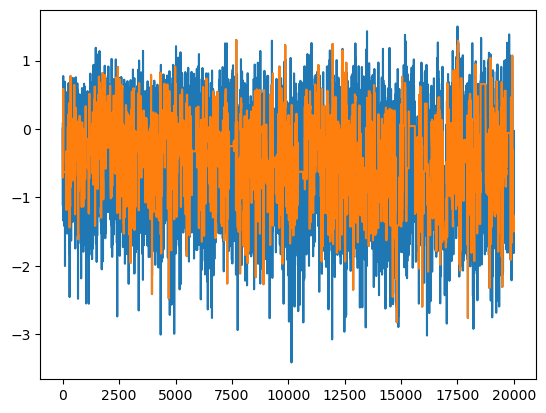

In [289]:
plt.plot(par[props, 5])
plt.plot(par[chain, 5])

In [282]:
np.unique(props).size

20000

In [301]:
import h5py
import numpy as np


def save_mlp_data_to_hdf5(
    filename: str,
    par: np.ndarray,
    obs: np.ndarray,
    y_obs: np.ndarray,
    logpi: np.ndarray,
    chain: np.ndarray,
    props: np.ndarray,
):
    """
    Save current in-memory arrays into an HDF5 file for MLP tests.

    Expected shapes:
      par   : (N, 30)
      obs   : (N, 52)
      y_obs : (52,)
      logpi : (N,)
      chain : (T,)
      props : (T,)
    """

    # Basic shape checks (optional but useful)
    N = par.shape[0]
    assert obs.shape[0] == N, "obs and par must have same first dimension"
    assert logpi.shape[0] == N, "logpi and par must have same first dimension"
    assert y_obs.shape[0] == obs.shape[1], "y_obs must match obs second dimension"
    assert chain.shape == props.shape, "chain and props must have the same shape"

    with h5py.File(filename, "w") as f:
        # Use gzip compression to keep file smaller (optional)
        f.create_dataset("par", data=par, compression="gzip")
        f.create_dataset("obs", data=obs, compression="gzip")
        f.create_dataset("y_obs", data=y_obs, compression="gzip")
        f.create_dataset("logpi", data=logpi, compression="gzip")
        f.create_dataset("chain", data=chain, compression="gzip")
        f.create_dataset("props", data=props, compression="gzip")

    print(f"Saved data to {filename}")


# Example usage *inside your current session*:
save_mlp_data_to_hdf5("data.h5", par, obs, y_obs, logpi, chain, props)

Saved data to data.h5


In [283]:
# Single chain
rate = acceptance_ratio(chain, props)  # default excludes self-proposals
rate_all, stats = acceptance_ratio(chain, props, exclude_self_proposals=False, return_counts=True)
print("acceptance (exclude self-proposals):", rate)
print("acceptance (include self-proposals):", rate_all)
print("overall state-change rate:", stats["overall_move_rate"])

acceptance (exclude self-proposals): 0.1295064753237662
acceptance (include self-proposals): 0.1295064753237662
overall state-change rate: 0.1295064753237662


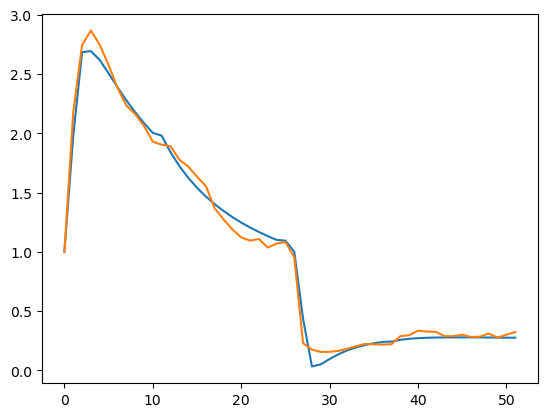

In [288]:
plt.plot(obs[np.argmax(logpi),:])
plt.plot(observations / 275.0)